<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#BERT" data-toc-modified-id="BERT-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>BERT</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-LogisticRegression" data-toc-modified-id="Модель-LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель <strong><em>LogisticRegression</em></strong></a></span></li><li><span><a href="#Модель-DecisionTreeClassifier" data-toc-modified-id="Модель-DecisionTreeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель <strong><em>DecisionTreeClassifier</em></strong></a></span></li><li><span><a href="#Модель-CatBoostClassifier" data-toc-modified-id="Модель-CatBoostClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Модель <strong><em>CatBoostClassifier</em></strong></a></span></li><li><span><a href="#Модель-LGBMClassifier" data-toc-modified-id="Модель-LGBMClassifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Модель <strong><em>LGBMClassifier</em></strong></a></span></li><li><span><a href="#Выбор-модели" data-toc-modified-id="Выбор-модели-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Выбор модели</a></span></li></ul></li><li><span><a href="#Тестирование-и-анализ-модели" data-toc-modified-id="Тестирование-и-анализ-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование и анализ модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Загрузка данных

In [1]:
# Импорт библиотек:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import os
import string
import torch
import transformers 
import time


from wordcloud import WordCloud
from tqdm import notebook
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve


from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk import word_tokenize

In [2]:
SEED = 42

In [3]:
# Открываем и сохраняем файл toxic_comments.csv в датафрейм:
pth1 = 'D:/DS/toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=0)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, index_col=0)
else:
    print('Something is wrong')

### Обзор данных

In [4]:
# Посмотрим полную информацию датафрейма: 
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [5]:
# Смотрим десять случайных строк:
data.sample(10)

text  toxic
108853  "\n\n CCF external link description \n\nPerson...      0
60862                         Ok, thanks in advance. (  )      0
122062  , 28 October 2010 (UTC)\nThere is a consensus,...      0
52876   You Suck\n Headline text \nStop editing my edi...      1
44990   "\n\n Please stop \nI have to ask that you sto...      0
77372   Mykungfu, if you are willing to come back and ...      0
148383  Wow, never expected a rude response such as th...      0
114806  If you want to make a change, use the Discussi...      0
48663   September 2007\nPlease do not add names of peo...      0
25059   "\nAll three are not definite until FOX confir...      0

In [6]:
# Проверим датасет на пропуски
print('Ко-во пропусков:\n', data.isna().sum())

Ко-во пропусков:
 text     0
toxic    0
dtype: int64


In [7]:
# Проверим датасет на дубликаты
print('Кол-во дубликатов:', data.duplicated().sum())

Кол-во дубликатов: 0


***Выводы***
* Исходный датасет содержит 159 292 записи и 3 колонки
* Согласно документации к данным, cтолбец `text` содержит текст комментария, а `toxic` — целевой признак.
* Датасет не содержит пропусков и дубликатов

In [8]:
# Применим downcast, чтобы уменьшить потребление памяти и ускорить работу.
df = data.copy()

df['toxic'] = pd.to_numeric(df['toxic'], downcast='integer')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 2.6+ MB


Посмотрим, какие слова чаще всего встречаются в токсичных и нетоксичных комментариях.

In [9]:
# Функция удаления из текста пунктуации:
def remove_chars_from_text(text, chars):
    return "".join([ch for ch in text if ch not in chars])

In [10]:
# Функция удаления стоп-слов из текста:
def text_cleanup(text):
    stopset = set(stop_words)
    cleanup = " ".join(filter(lambda word: word not in stopset, text.split()))
    return cleanup

In [11]:
def make_fdist(n):
    if (n == 1) or (n == 0):
        corpus = df.loc[df['toxic'] == n, 'text'].values #.astype('U')  
        text = ' '.join(corpus)
        text = text.lower()
        text = remove_chars_from_text(text, spec_chars)
        text = remove_chars_from_text(text, string.digits)
        text_cleaned = text_cleanup(text)
        tokens = word_tokenize(text_cleaned)
        text_cleaned = nltk.Text(tokens)    
        if n == 0:
            colormap='summer'
            color='darkgreen'
            title='Самые частые слова в нетоксичных комментариях'
            
        else: 
            colormap = 'winter'
            color='red'
            title='Самые частые слова в токсичных комментариях'
        fdist = FreqDist(text_cleaned) 
        fdist.plot(15, cumulative=False, color=color)
        text_raw = " ".join(text_cleaned)    
        wordcloud = WordCloud(width=800, 
                      height=500, 
                      max_words=150, 
                      colormap=colormap, 
                      background_color ='white', 
                      collocations=False).generate(text_raw)
        plt.figure(figsize=(8,6))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title(title);
    else: print('put 1 or 0')    

In [12]:
# Определим наборы спецсимволов и стоп-слов для удаления:
spec_chars = string.punctuation + '\n\xa0' 
stop_words = stopwords.words('english')
stop_words.extend(['u', 'im', 'dont' ])

График часто встречающихся слов для нетоксичных комментариев:

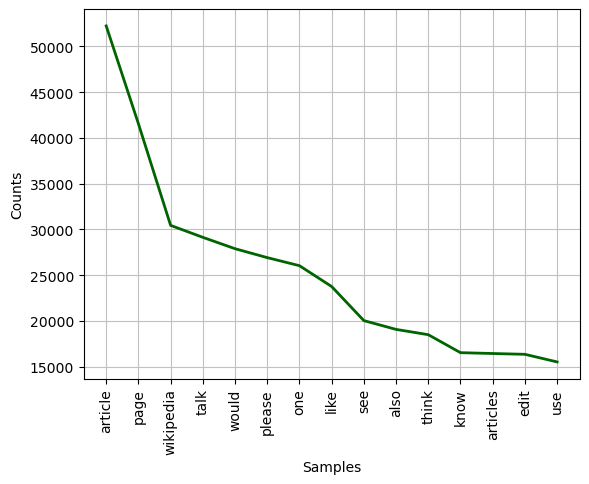

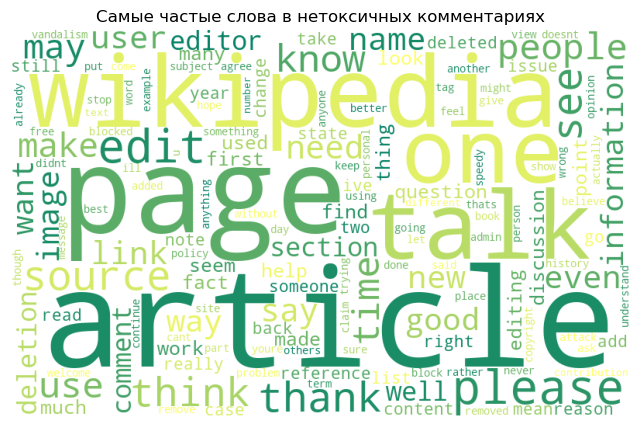

In [13]:
make_fdist(0)

График часто встречающихся слов для токсичных комментариев:

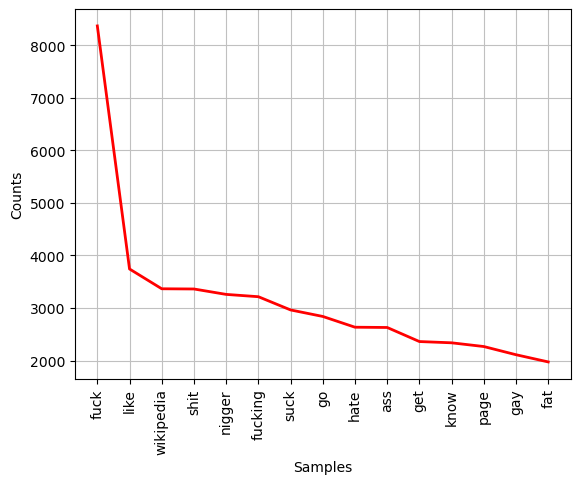

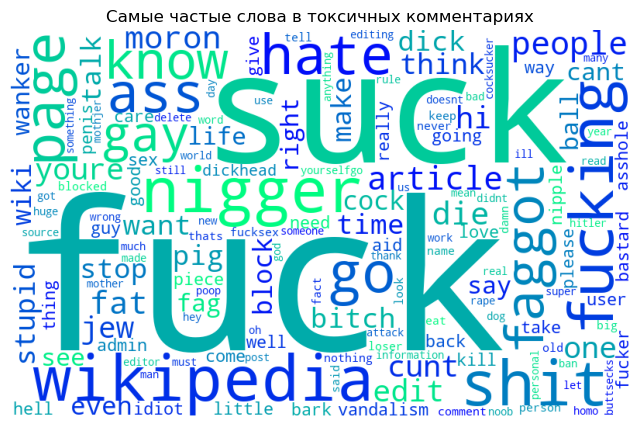

In [14]:
make_fdist(1)

В обоих наборах третье место - `wikipedia`

In [15]:
# Подсчитываем кол-во слов в текстах
word_counts = df['text'].apply(lambda x: len(x.split()))
word_counts.describe()

count    159292.000000
mean         67.213545
std          99.133908
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: text, dtype: float64

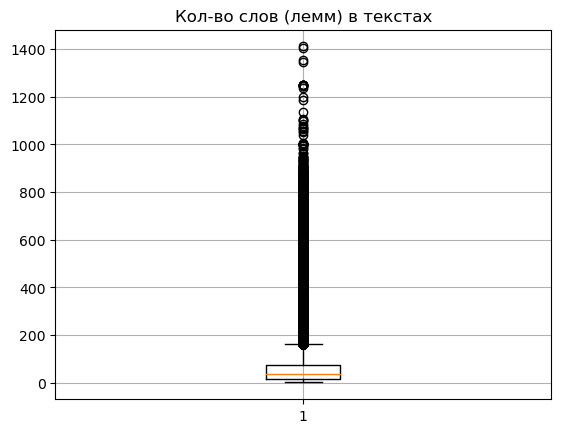

In [16]:
# Строим диаграмму размаха:
plt.boxplot(word_counts.values)
plt.grid(True)
plt.title('Кол-во слов (лемм) в текстах');

***Выводы:***
* в среднем один текст содержит 67 слов (лемм)
* 25% текстов очень короткие и содержат до 17 слов (лемм)
* половина текстов содержат до 36 слов (лемм)
* 75% текстов содержат до 75 слов (лемм)
* имеются выбросы, максимальное кол-во слов (лемм) в тексте = 1 411

### Подготовка данных

Посмотрим на баланс классов:

toxic
0    0.898388
1    0.101612
Name: proportion, dtype: float64


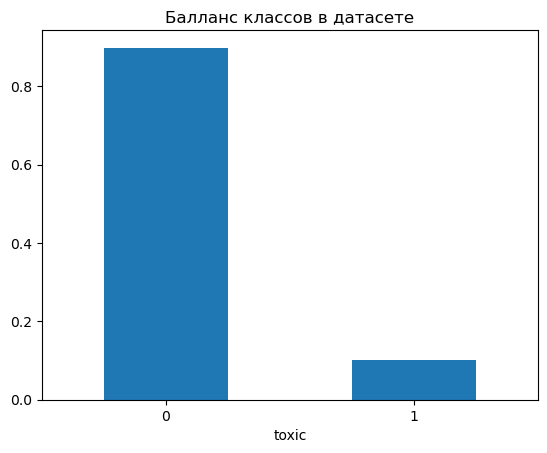

In [17]:
class_frequency = df['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Балланс классов в датасете');

Т.к для `Bert` датафрейм достаточно большой, возьмем 7500 случайных строк, чтобы обучение не было слишком долгим. 

In [18]:
df = df.sample(7500).reset_index(drop=True)
df.shape

(7500, 2)

toxic
0    0.898133
1    0.101867
Name: proportion, dtype: float64


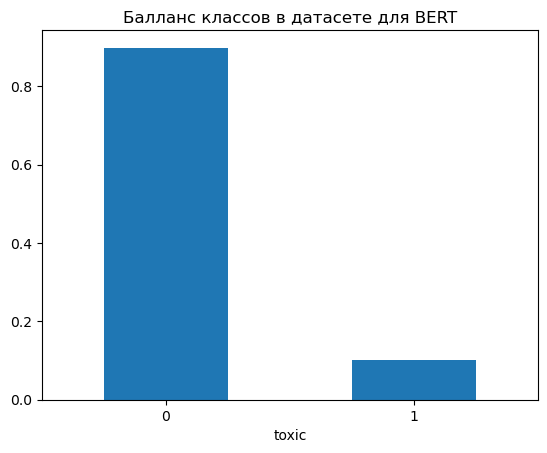

In [19]:
class_frequency = df['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Балланс классов в датасете для BERT');

***Вывод:***
* баланс целевого признака соотносится как 9 к 1 (90% записей с позитивной коннотацией, 10% записей с токсичной)
* для повышения качества обучения, чтобы модель имела больше шансов корректно определять 1, миноритарный класс, принято решение применить `stratify` при разделении выборок в `train_test_split` и посмотреть что из этого получится.

### BERT

Инициализируем токенизатор и преобразуем текст в номера токенов из словаря:

In [21]:
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

df['tokenized'] = df['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))

Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors


#Используем только векторы с длиной до 512, чтобы избежать ошибок.

In [22]:
MAX_LEN = 400
tokenized_proper = []                   # создаем пустой спиок для сохранения подходящих векторов
target = []                             # и список для соответствующих значений из df['toxic']

for i in range(df.shape[0]):
    if len(df['tokenized'][i]) <= MAX_LEN:
        tokenized_proper.append(df['tokenized'][i])
        target.append(df['toxic'][i])

In [23]:
tokenized_proper = pd.Series(tokenized_proper)
target = pd.Series(target)

Применим метод padding, чтобы уравнять длины всех векторов, а также определим attention_mask, которая покажет модели, что нули не несут значимой информации:

In [24]:
padded = np.array([i + [0]*(MAX_LEN - len(i)) for i in tokenized_proper])
attention_mask = np.where(padded != 0, 1, 0) 

Инициализируем модель:

In [25]:
bert_model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')

Преобразуем токенизированные тексты в эмбеддинги:

In [26]:
%%time

batch_size = 750
embeddings = []
for i in notebook.tqdm(range((padded.shape[0] // batch_size)+1)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = bert_model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: total: 4h 14min 20s
Wall time: 29min 7s


In [27]:
# Соберем в матрицу признаков:
features = np.concatenate(embeddings)

print(features.shape)
print(target.shape)

(7332, 768)
(7332,)


## Обучение

Разделим датасет на обучающую и тестовую выборки:

In [28]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=SEED, stratify=target)

print(X_train.shape)
print(X_test.shape)

(5865, 768)
(1467, 768)


In [29]:
# Функция для поиска лучшего значения F1:

def best_f1(model, params):
    grid = GridSearchCV(model, params, scoring='f1') 
    grid.fit(X_train, y_train)
    f1 = grid.best_score_
    print(grid.best_estimator_)
    print('F1-мера на обучающей выборке:', round(f1, 3))
    return f1, grid.best_estimator_

### Модель ***LogisticRegression***

In [30]:
%%time

params = {}

f1_lr, model_lr = best_f1(LogisticRegression(random_state=SEED, solver='liblinear'), params)

LogisticRegression(random_state=42, solver='liblinear')
F1-мера на обучающей выборке: 0.945
CPU times: total: 2.7 s
Wall time: 2.83 s


### Модель ***DecisionTreeClassifier***

In [31]:
%%time

params = {'max_depth': range (1, 7),
          'min_samples_split': range (2, 7),
          'min_samples_leaf' : range(2, 7) }


f1_dt, model_dt = best_f1(DecisionTreeClassifier(random_state=SEED), params)

DecisionTreeClassifier(max_depth=1, min_samples_leaf=2, random_state=42)
F1-мера на обучающей выборке: 0.938
CPU times: total: 26min 45s
Wall time: 27min 23s


### Модель ***CatBoostClassifier***

In [32]:
%%time

params = {}

f1_cb, model_cb = best_f1(CatBoostClassifier(verbose=False, iterations=300,learning_rate=0.001, random_state=SEED), params)

F1-мера на обучающей выборке: 0.942
CPU times: total: 12min 8s
Wall time: 51.5 s


### Модель ***LGBMClassifier***

In [33]:
%%time

params =  {'n_estimators': range(10, 155, 15),
           'max_depth': range (1,15),
           'num_leaves': range (2,50, 10)}

f1_lgbm, model_lgbm = best_f1(LGBMClassifier(force_col_wise=True, learning_rate = 0.1, random_state=42), params)

[LightGBM] [Info] Number of positive: 479, number of negative: 4213
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4692, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.102089 -> initscore=-2.174230
[LightGBM] [Info] Start training from score -2.174230
[LightGBM] [Info] Number of positive: 479, number of negative: 4213
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4692, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.102089 -> initscore=-2.174230
[LightGBM] [Info] Start training from score -2.174230
[LightGBM] [Info] Number of positive: 478, number of negative: 4214
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4692, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101876 -> initscore=-2.176557
[LightGBM] [Info] Start training from score -2.176557
[LightG

### Выбор модели

Объединим результаты в одну таблицу: 

In [34]:
results = pd.DataFrame([
    [f1_lr],
    [f1_dt],
    [f1_cb],
    [f1_lgbm]], 
    columns=['F1'],
    index=['LogisticRegression', 'DecisionTree', 'CatBoost', 'LGBM'])
results.sort_values(by='F1', ascending=False)

F1
LGBM                0.948962
LogisticRegression  0.945477
CatBoost            0.942308
DecisionTree        0.937822

***Вывод:*** 
- Все модели преодолели планку в F-1 >= 0.75.
- Лучшей моделью по F1-мере является `LGBMClassifier` опережающей `LogisticRegression` на 0.3 %. Однако `LogisticRegression` требуется в десятки раз меньше затрачиваемого времени (30 сек против 26 минут). Поэтому выбор однозначен - `LogisticRegression`

## Тестирование и анализ модели

In [35]:
pred_test = model_lr.predict(X_test)
print('F1-мера на тестовой выборке:', round(f1_score(y_test, pred_test), 3))

F1-мера на тестовой выборке: 0.97


F1-мера на тестовой выборке: 0.97. Выбранная модель не переобучилась. Задача: значение метрики F1 не меньше 0.75 - выполнена.

Матрица ошибок для модели LogisticRegression:

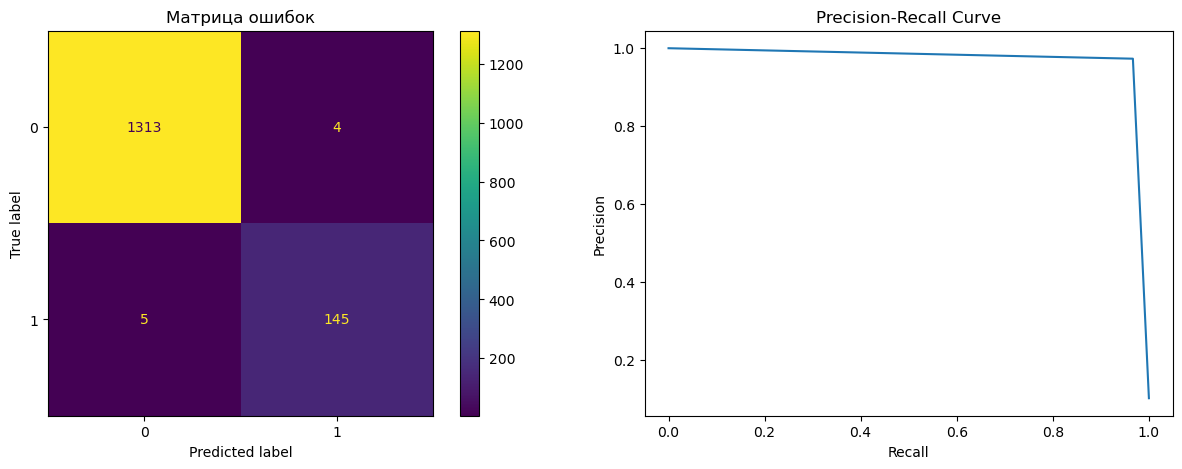

In [36]:
cm = confusion_matrix(y_test, pred_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_lr.classes_)
disp.plot(ax=ax1)
ax1.set_title('Матрица ошибок')

precision, recall, thresholds = precision_recall_curve(y_test, pred_test)
ax2.plot(recall, precision)
ax2.set_title('Precision-Recall Curve')
ax2.set_ylabel('Precision')
ax2.set_xlabel('Recall')
plt.show()

In [39]:
TN = cm[0][0]
TP = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
total = cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0]

print('Всего предсказаний:',total)
print(f'Правильно классифицированные: {np.round((TP+TN)/total*100)}%')
print(f'Правильно классифицированные токсичные соообщения: {np.round(TP/(TP+FN)*100)}%')
print(f'Правильно классифицированое не токсичные сообщения: {np.round(TN/(TN+FP)*100)}%')
print(f'Прогнозируемые токсичные соообщения, соответствующая действительности: {np.round(TP/(TP+FP)*100)}%')
print(f'Прогнозируемые не токсичные сообщения, которых так же на самом деле нет: {np.round(TN/(TN+FN)*100)}%')

Всего предсказаний: 1467
Правильно классифицированные: 99.0%
Правильно классифицированные токсичные соообщения: 97.0%
Правильно классифицированое не токсичные сообщения: 100.0%
Прогнозируемые токсичные соообщения, соответствующая действительности: 97.0%
Прогнозируемые не токсичные сообщения, которых так же на самом деле нет: 100.0%


## Выводы

Задача по обучению модели классифицировать комментарии на позитивные и негативные была выполнена с помощью предобученной модели BERT(toxic-bert). Наилучшей моделью для выполнения задачи является модель `LogisticRegression`, со значением F1-меры в 0.97, что превышает заданное значение в F1-меры >=0.75.

В ходе работы были выполнены следующие шаги:

 - Загрузка и чтение данные. 
    * Исходный датасет содержит 159 292 записи и 3 колонки
    * Согласно документации к данным, cтолбец `text` содержит текст комментария, а `toxic` — целевой признак.
    * Датасет не содержит пропусков и дубликатов;
 - Провели частотный анализ текста - построили график и облако слов для наиболее встречающихся слов в текстах.
    * в среднем один текст содержит 67 слов (лемм)
    * 25% текстов очень короткие и содержат до 17 слов (лемм)
    * половина текстов содержат до 36 слов (лемм)
    * 75% текстов содержат до 75 слов (лемм)
    * имеются выбросы, максимальное кол-во слов (лемм) в тексте = 1 411; 
 - Преобразовали тексты при помощи предобученной модели BERT(toxic-bert);
 - Обучили различные модели;  
 - Выбрали и проверили на тесте лучшую модель.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны